In [47]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from joblib import load
import waterfall_chart

## Stare dane i model

In [14]:
forest = load('../PD1/forest.joblib')
data = pd.read_pickle('../PD1/processed_data.pkl')

In [15]:
data = data.iloc[:,:-1]
data.head()

,InternetAccessFrq,PartnerAge,FirstMetPartnerYr,InternetDating,InterviewDuration
0,2,26.0,2017.0,1,9
1,2,52.0,1983.0,0,11
2,2,45.0,2006.0,0,7
3,2,26.0,2012.0,0,5
4,2,59.0,1983.0,0,13


## Odpowiedzi modelu

In [50]:
from itertools import permutations

def _make_series(x: tuple) -> pd.Series:
    vs = []
    ns = []
    for (v, n) in x:
        vs.append(v)
        ns.append(n)
    return pd.Series(vs, index = ns)


def make_permutations(sample: pd.Series) -> list:
    tups = [(v, n) for v, n in zip(sample, sample.index)]
    return list(map(_make_series, list(permutations(tups))))
    

def mean_resp(model, data: pd.DataFrame, sample: pd.Series) -> pd.Series:
    assert hasattr(model, 'predict_proba')
    df = data.copy()
    
    # alias
    pred = lambda x : model.predict_proba(x)[:,1]
    
    # mean response
    output = [np.mean(pred(data))]
    
    # change value, check response, keep only diff
    previous = output[0]
    for c in sample.index:
        df[c] = sample[c]
        m = np.mean(pred(df))
        output.append(m - previous)
        previous = m
   
    index = ['base'] + list(sample.index)
    # Make a not so nice waterfall...
    waterfall_chart.plot(index, output, Title='Mean response', 
                         formatting='{:,.3f}', rotation_value=60)
    return pd.Series(output, index = index)
    
        

In [17]:
# Random sample in series format
sample = data.sample(1).iloc[0,:]

# Make more samples based on selected one:
samples = make_permutations(sample)

base                 0.615767
InternetAccessFrq    0.006486
FirstMetPartnerYr    0.097795
PartnerAge           0.147530
InterviewDuration   -0.014929
InternetDating       0.008591
dtype: float64

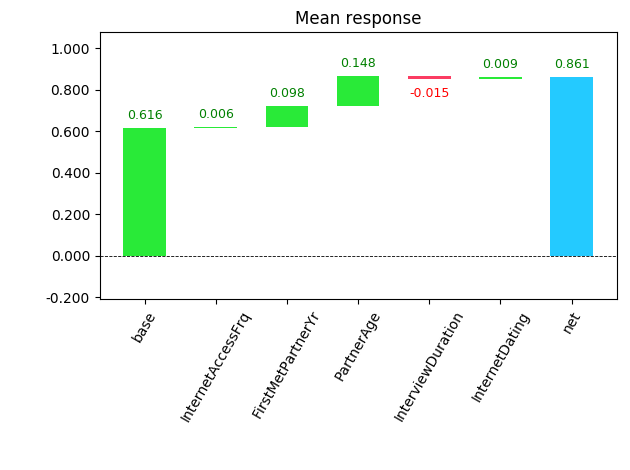

In [51]:
idx = 7
mean_resp(forest, data, samples[idx])

base                 0.615767
InternetDating      -0.001988
InterviewDuration   -0.002394
PartnerAge          -0.016947
FirstMetPartnerYr    0.259561
InternetAccessFrq    0.007241
dtype: float64

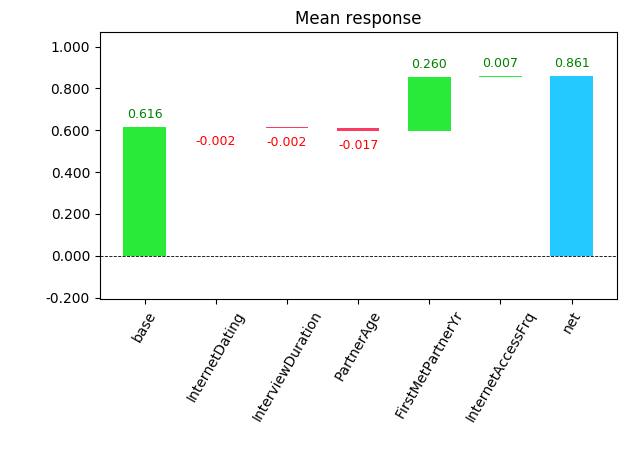

In [52]:
mean_resp(forest, data, samples[idx][::-1])

Całkowite odwrócenie kolejności zmiennych wydaje sie nie mieć znacznego wpływu na znaczenie `InternetDating` oraz `InternetAccessFreq`. Zauważalna jest natomiast zmiana w przypadku wieku partnera `PartnerAge` oraz roku w którym partnerzy się spotkali `FirstMetPartnerYr`. 

Co więcej podobną zmianę w wieku partnera otrzymujemy jeśli zamienimy jedynie miejscami `FirstMetPartnerYr` z `InterviewDuration`. 

base                 0.615767
InternetAccessFrq    0.006486
InterviewDuration   -0.005265
PartnerAge          -0.009445
FirstMetPartnerYr    0.245105
InternetDating       0.008591
dtype: float64

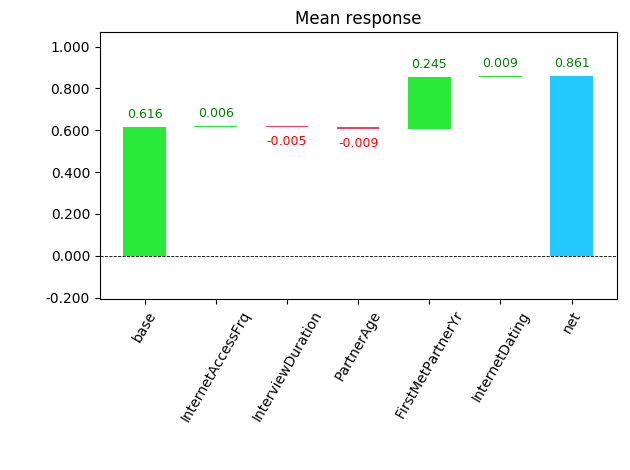

In [54]:
smp = pd.Series([2., 15., 59., 1969., 0.], 
                index=['InternetAccessFrq', 'InterviewDuration', 'PartnerAge', 'FirstMetPartnerYr', 'InternetDating'])
mean_resp(forest, data, smp)

Wyrzucając zmienne `InternetDating` oraz `InternetAccessFreq` zachowujemy podobną charakterystykę.

base                 0.615767
InterviewDuration   -0.003261
PartnerAge          -0.008083
FirstMetPartnerYr    0.240286
dtype: float64

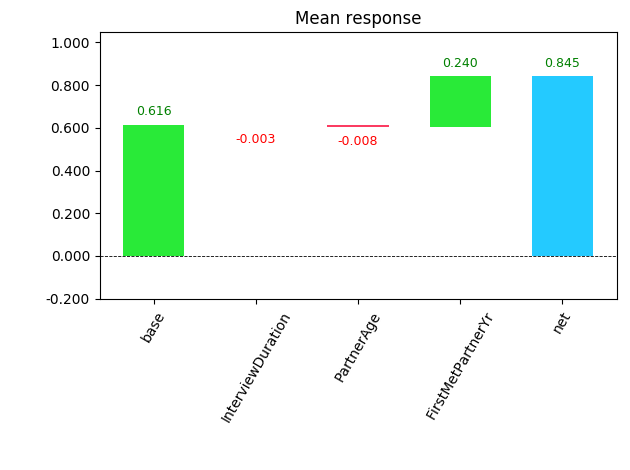

In [56]:
smp = pd.Series([15., 59., 1969.], 
                index=['InterviewDuration', 'PartnerAge', 'FirstMetPartnerYr'])
mean_resp(forest, data, smp)

Powrót do kolejności zgodnej z pierwotną sugeruje, że to zmienne ciągłe mogą najbardziej wpływać na podziały.

base                 0.615767
FirstMetPartnerYr    0.104076
PartnerAge           0.139665
InterviewDuration   -0.014800
dtype: float64

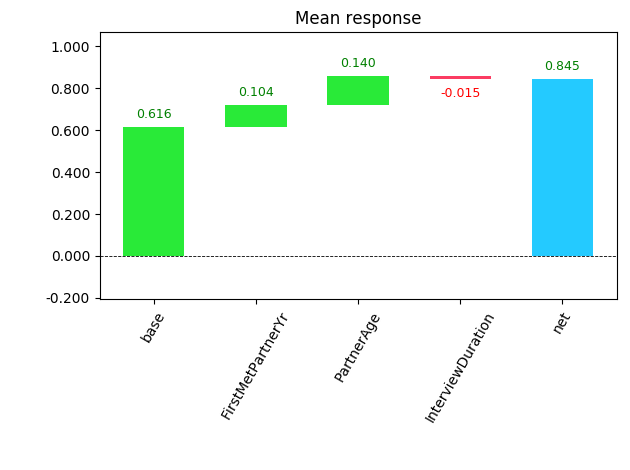

In [58]:
smp = pd.Series([15., 59., 1969.][::-1], 
                index=['InterviewDuration', 'PartnerAge', 'FirstMetPartnerYr'][::-1])
mean_resp(forest, data, smp)